# The Problem
The $k$-armed bandits problem refers to a classic problem in reinforcement learning:
A person is faced with $k$ slot machines, and is tasked with pulling one of them repeatedly. Of course, the person does not know the probabilities of success for each machine. They only can estimate these probabilities from past performance. They have to chose between sticking with the most favorable machine until now or going with one that seems less favorable but could still be the best one.


In our reference book, the bandit follow a normal distribution. In this implementation, we will compare our reference bandit to a custom one that will have a uniform distribution on 10 random values between -1 and 1.  We want to compare those two cases, to see if those two setting are somehow different. By law of large numbers, the bandits act the same if we pull them sufficiently many times, but it could be the case the change on the distribution yields to dramatically different strategies, and that not the same bandits at all are pulled - cancelling the law of large number. Let us see that in practice.

The first approach is to compare greedy and $\epsilon$-greedy algorithms. The first one always chooses the action that has the highest expected reward. The second one chooses with probability $\epsilon$ a random action and with probability $1-\epsilon$ the action with the highest expected reward. A greedy algorithm always exploit the best possibility. An $\epsilon$-greedy algorithm chose sometimes to explore. Another algorithm will be the optismistic one. We will see it in detail later, but it explores a lot at the beginning, then it exploits the best action. We introduce the optimistic $\epsilon$-greedy algorithm. It explores a lot at the beginning, but also explore occasionally. Our goal is to compare those 4 algorithms on the 2 settings.

# Setup

We start by importing the requested libraries and by setting constants.

In [5]:
#library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
#basic constant
TRIALS = 200
NUMBER_OF_BANDITS = 15
NUMBER_OF_VALUES_ON_EACH_BANDIT = 5
MAX_VALUE_OF_ACTION = 1
MIN_VALUE_OF_ACTION = -1
OPTIMISM = 0
EPSILON = 0.1

We create two classes: the ``` class RandomValueBandit```, corresponding to our custom setting, and the ```class NormalBandit```, corresponding to the classical case.

In [6]:
#we create bandit class
class RandomValueBandit:
    def __init__(self, max=MAX_VALUE_OF_ACTION,min=MIN_VALUE_OF_ACTION,number_of_outcomes=NUMBER_OF_VALUES_ON_EACH_BANDIT,optimism=OPTIMISM):
       self.values = []
       self.numberOfPulls = 0
       self.optimism = optimism
       self.meanOfPulls = self.optimism
       self.min=min
       self.max=max
       self.number_of_outcomes = number_of_outcomes
       for i in range(number_of_outcomes):
           self.values.append(np.random.random() * (max - min) + min)
    
    def reset_values(self):
        self.values = []
        for i in range(self.number_of_outcomes):
            self.values.append(np.random.random() * (self.max - self.min) + self.min)
        self.reset_pulls()
    
    def pull(self):
        self.numberOfPulls += 1
        result = np.random.choice(self.values)
        self.meanOfPulls += ( result - self.meanOfPulls) /self.numberOfPulls
        return result
    
    def __str__(self):
        return str(self.values)
    
    def return_values(self):
        return self.values
    
    def reset_pulls(self, optimism=None):
        self.numberOfPulls = 0
        if optimism is None:
            optimism = self.optimism
        self.meanOfPulls = optimism
        
    def expected_mean(self):
        return self.meanOfPulls
    def mean(self):
        return np.mean(self.values)

In [7]:
#we create the tradition bandit class following a normal distribution with mean m
class NormalBandit:
    def __init__(self, mean,optimism=OPTIMISM):
        self.mean = mean
        self.numberOfPulls = 0
        self.optimism = optimism
        self.meanOfPulls = self.optimism
    
    def reset_pulls(self,optimism=None):
        self.numberOfPulls = 0
        if optimism is None:
            optimism = self.optimism
        self.meanOfPulls = optimism
    
    def reset_mean(self,mean):
        self.mean = mean
        self.reset_pulls()
        
    def expected_mean(self):
        return self.meanOfPulls
    
    def pull(self):
        self.numberOfPulls += 1
        result = np.random.randn() + self.mean
        self.meanOfPulls += ( result - self.meanOfPulls) /self.numberOfPulls
        return result

The algorithms will share a lot of code. We write a unique function that will be called by each of them.

In [24]:
def algo_bandit(epsilon=0,optimism=OPTIMISM, verbose=False):
    for bandit in rvBandit:
        bandit.reset_pulls(optimism)
    for bandit in nBandit:
        bandit.reset_pulls(optimism)

    rvAction=[0]
    nAction = [0]
    rvResults = [rvBandit[0].pull()]
    nResults = [nBandit[0].pull()]

    for i in range(1,TRIALS):
        if np.random.rand() < epsilon:
            rvAction.append(np.random.randint(0,len(rvBandit)))
            nAction.append(np.random.randint(0,len(nBandit)))
            if verbose:
                print("random action taken:",rvAction[i]," and ",nAction[i])
        else:
            rvAction.append(arg_max([bandit.expected_mean() for bandit in rvBandit]))
            nAction.append(arg_max([bandit.expected_mean() for bandit in nBandit]))
        rvResults.append(rvBandit[rvAction[i]].pull()+rvResults[i-1])
        nResults.append(nBandit[nAction[i]].pull()+nResults[i-1])
    return rvAction,nAction,rvResults,nResults

def arg_max(list):
    return random.choice(np.argwhere(list==np.amax(list)).flatten().tolist())

# Initialization of the bandits 

In [9]:
#we initialize the bandits
rvBandit=[]
nBandit=[]
for i in range(NUMBER_OF_BANDITS):
    rvBandit.append(RandomValueBandit())
    nBandit.append(NormalBandit(rvBandit[i].mean()))

Let us show the values of each bandit. The mean is represented by a black square.

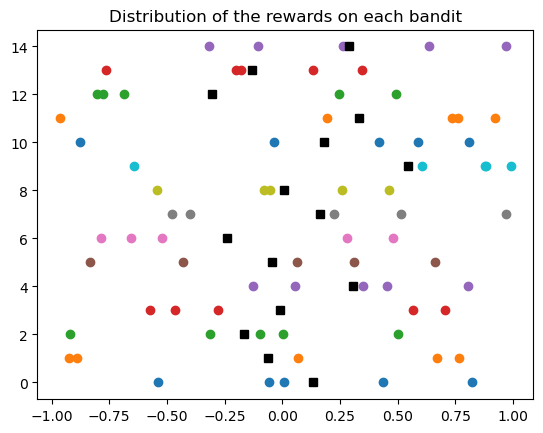

In [10]:
fig, ax = plt.subplots()
for i in range(NUMBER_OF_BANDITS):
    ax.plot(rvBandit[i].return_values(), [i]*NUMBER_OF_VALUES_ON_EACH_BANDIT, 'o')
ax.plot([bandit.mean() for bandit in rvBandit],range(NUMBER_OF_BANDITS), 's', color='black')
plt.title("Distribution of the rewards on each bandit")
plt.show()

# Preliminary study: comparison on the settings for one particular set of values

We implement our bandit algorithms in Python. An omniscient agent would each time take the bandit with the highest expected reward. This is the optimal - yet impossible to reach - strategy. We will compare the performance of the different algorithms w.r.t. this optimal strategy.

### Optimal strategy

But to begin, we will see that indeed, the law of large number implies that for this optimal play this is equivalent to play in with normal distribution bandit or with our custom one.

In [11]:
best_bandit = np.argmax([bandit.mean() for bandit in rvBandit])
print("Best bandit: ", best_bandit)

Best bandit:  9


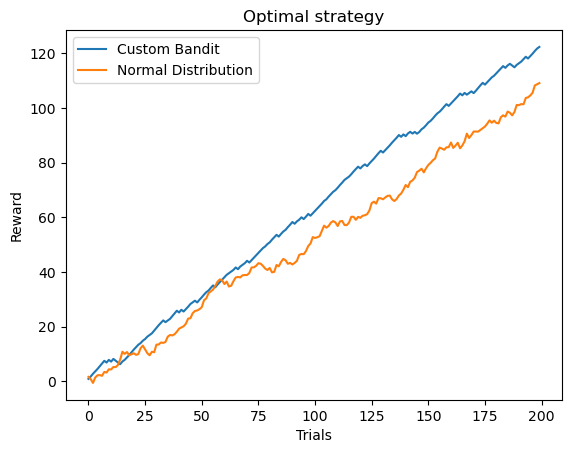

In [12]:
rvResultsOptimal = [rvBandit[best_bandit].pull()]
nResultsOptimal = [nBandit[best_bandit].pull()]
for i in range(1,TRIALS):
    rvResultsOptimal.append(rvBandit[best_bandit].pull()+rvResultsOptimal[i-1])
    nResultsOptimal.append(nBandit[best_bandit].pull()+nResultsOptimal[i-1])
fig,ax = plt.subplots()
ax.plot(range(TRIALS),rvResultsOptimal, label="Custom Bandit")
ax.plot(range(TRIALS),nResultsOptimal, label="Normal Distribution")
ax.set_xlabel("Trials")
ax.set_ylabel("Reward")
ax.legend()
plt.title("Optimal strategy")
plt.show()


Of course, the reward being random, the two curves does not fit perfectly, but still are very close one to the other.

Now comes the comparison for the greedy and $\epsilon$-greedy algorithms.

### Greedy Strategy

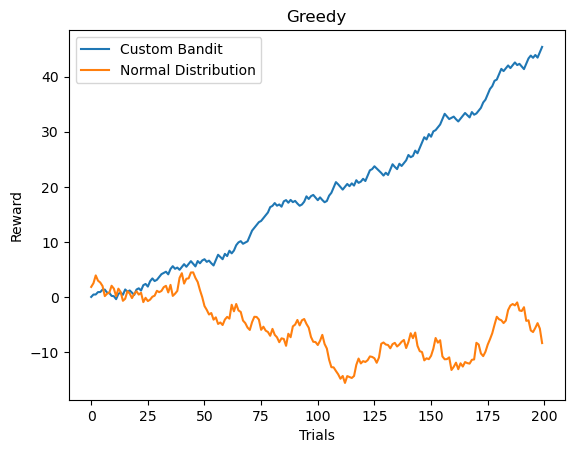

In [13]:

rvAction, nAction, rvResultsGreedy, nResultsGreedy = algo_bandit()
fig,ax = plt.subplots()
ax.plot(range(TRIALS),rvResultsGreedy, label="Custom Bandit")
ax.plot(range(TRIALS),nResultsGreedy, label="Normal Distribution")
ax.set_xlabel("Trials")
ax.set_ylabel("Reward")
ax.legend()
plt.title("Greedy")
plt.show()

In [14]:
print("best bandit:" , best_bandit, "\n")
print("greedy custom:\n",pd.Series(rvAction).value_counts(),"\n")
print("greedy normal:\n",pd.Series(nAction).value_counts())

best bandit: 9 

greedy custom:
 7    188
0     12
Name: count, dtype: int64 

greedy normal:
 8     97
2     49
0     16
14    13
6     10
4      3
11     2
1      2
13     2
3      1
10     1
5      1
12     1
9      1
7      1
Name: count, dtype: int64


By running the code several times, we will remark that it is not unusual that the greedy algorithm don't even test the optimal bandit. We have to find a way to push it to explore more. We talk about $\epsilon$-greedy, but before that, we will try to make our algorithm "optimistic".

### Optimistic starting values

 If our algorithm start with the belief that the mean of our bandit is bigger than 0, it will be more likely to explore, as it will likely be disappointed by each machine after a few pulls. After running out of novelties, it should keep more focus on good machine. Now, the question is how optimistic should the algorithm be? This, as many things, depends too much on the problem, but we can keep in mind that the more optimistic, the more likely it is that the algorithm will explore.

We reset our machine, and make the algorithm optimistic. We chose an estimation of the mean at 0.5, which is far too much. The sum of uniform distribution follow Irwin–Hall distribution. We can use it to see that the probability of a mean at 0.5 or more for our bandit is as close to 0 as we can hope. If we wanted to have an optimal optimism, we could however use said distribution to have the way lower optimism and still a low probability that the mean of any bandit is higher than it. However, it supposes a lot of knowledge about the bandit distribution, knowledge which is not always available. Here too, we must work on a case by case basis.

In [15]:
for bandit in rvBandit:
    bandit.reset_pulls(optimism=0.5)
for bandit in nBandit:
    bandit.reset_pulls(optimism=0.5)

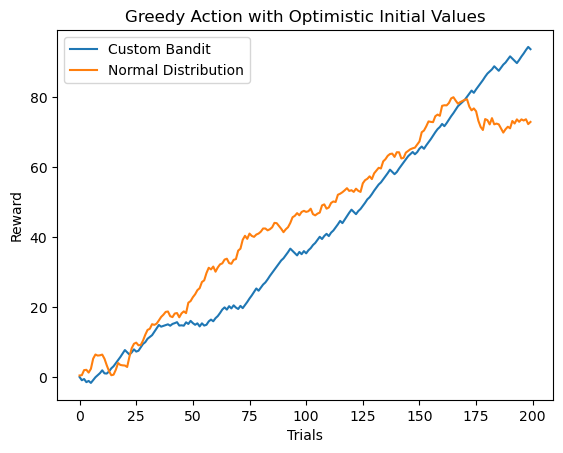

In [16]:
rvActionOptimistic, nActionOptimistic, rvResultsGreedyOptimistic, nResultsGreedyOptimistic = algo_bandit(optimism=0.5)

# Plotting
fig,ax = plt.subplots()
ax.plot(range(TRIALS),rvResultsGreedyOptimistic, label="Custom Bandit")
ax.plot(range(TRIALS),nResultsGreedyOptimistic, label="Normal Distribution")
ax.set_xlabel("Trials")
ax.set_ylabel("Reward")
ax.legend()
plt.title("Greedy Action with Optimistic Initial Values")
plt.show()

In [17]:
print("best bandit:" , best_bandit, "\n")
print("optimistic greedy custom:\n",pd.Series(rvActionOptimistic).value_counts(),"\n")
print("optimistic greedy normal:\n",pd.Series(nActionOptimistic).value_counts())

best bandit: 9 

optimistic greedy custom:
 9     156
7      24
10      8
0       1
2       1
13      1
1       1
4       1
3       1
8       1
12      1
6       1
11      1
5       1
14      1
Name: count, dtype: int64 

optimistic greedy normal:
 11    121
4      51
5       8
10      6
8       3
1       2
0       1
9       1
13      1
14      1
7       1
2       1
3       1
12      1
6       1
Name: count, dtype: int64


We see here a far better exploration of the environment.

### The $\epsilon$-greedy algorithms

Finally, we impliment the $\epsilon$-greedy algorithms. Once realistic, once optimistic. Our goal here is to be sure the algorithm are well implemented and that there is sufficent exploration. There is not much more we can say on a unique iteration.

random action taken: 9  and  0
random action taken: 2  and  6
random action taken: 4  and  6
random action taken: 5  and  6
random action taken: 12  and  7
random action taken: 0  and  9
random action taken: 13  and  14
random action taken: 4  and  0
random action taken: 0  and  5
random action taken: 2  and  6
random action taken: 5  and  0
random action taken: 1  and  7
random action taken: 4  and  11
random action taken: 3  and  4
random action taken: 11  and  11
random action taken: 9  and  9
random action taken: 11  and  9
random action taken: 9  and  0
random action taken: 1  and  4
random action taken: 3  and  3
random action taken: 9  and  12
random action taken: 10  and  10
random action taken: 2  and  5
random action taken: 6  and  13
random action taken: 6  and  13


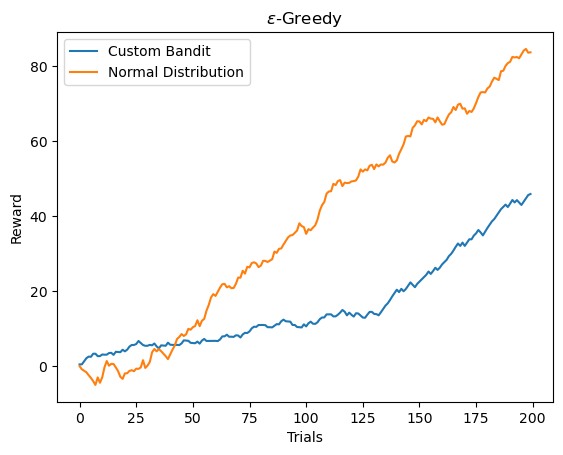

In [25]:
rvActionEpsilon, nActionEpsilon,rvResultsEpsilonGreedy,nResultsEpsilonGreedy = algo_bandit(epsilon=0.1,verbose=True)

#plotting
fig,ax = plt.subplots()
ax.plot(range(TRIALS),rvResultsEpsilonGreedy, label="Custom Bandit")
ax.plot(range(TRIALS),nResultsEpsilonGreedy, label="Normal Distribution")
ax.set_xlabel("Trials")
ax.set_ylabel("Reward")
ax.legend()
plt.title("$\epsilon$-Greedy")
plt.show()

In [27]:
print("best bandit:" , best_bandit, "\n")
print("e-greedy custom:\n",pd.Series(rvActionEpsilon).value_counts(),"\n")
print("e-greedy normal:\n",pd.Series(nActionEpsilon).value_counts())

best bandit: 9 

e-greedy custom:
 0     107
9      62
3       7
2       6
12      4
4       3
5       3
1       2
11      2
6       2
13      1
10      1
Name: count, dtype: int64 

e-greedy normal:
 9     135
0      21
11     20
6       5
4       3
13      3
7       3
3       2
14      2
12      2
5       2
1       1
10      1
Name: count, dtype: int64


There must be around 20 steps that had be taken randomly, and all other steps were explotation. However, it was enough to get a rather good exploration.

And the optimistic $\epsilon$-greedy:

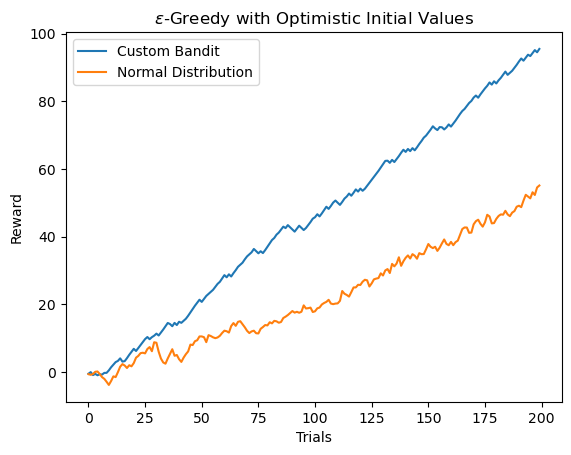

In [20]:
rvActionEpsilonOptimistic,nActionEpsilonOptimistic, rvResultsEpsilonGreedyOptimistic,nResultsEpsilonGreedyOptimistic = algo_bandit(epsilon=0.1,optimism=0.5)

#Plotting
fig,ax = plt.subplots()
ax.plot(range(TRIALS),rvResultsEpsilonGreedyOptimistic, label="Custom Bandit")
ax.plot(range(TRIALS),nResultsEpsilonGreedyOptimistic, label="Normal Distribution")
ax.set_xlabel("Trials")
ax.set_ylabel("Reward")
ax.legend()
plt.title("$\epsilon$-Greedy with Optimistic Initial Values")
plt.show()

In [21]:
print("best bandit:" , best_bandit, "\n")
print("optimistic e-greedy custom:\n",pd.Series(rvActionEpsilonOptimistic).value_counts(),"\n")
print("optimistic e-greedy normal:\n",pd.Series(nActionEpsilonOptimistic).value_counts())

best bandit: 9 

optimistic e-greedy custom:
 9     162
11     12
0       5
14      5
7       4
4       2
8       2
2       2
5       2
12      1
10      1
6       1
13      1
Name: count, dtype: int64 

optimistic e-greedy normal:
 11    111
4      41
10     12
2       8
8       6
7       5
9       5
14      3
6       3
0       1
12      1
3       1
1       1
13      1
5       1
Name: count, dtype: int64


We see here a good amount of exploration! It should indeed be the algorithm that explores most.

# Algorithm comparison
We finally plot all the results together. To have more precision, we run the algorithm 20 times for each configuration, and we take 200 configurations. We first write the common code to run the algorithm.

In [2]:
def iterate_bandit(n_iter, epsilon=0, optimism=0):
    rvResults = np.zeros(TRIALS)
    nResults= np.zeros(TRIALS)
    for n in range(n_iter):
        _, _,rvResultsIter,nResultsIter = algo_bandit(epsilon=epsilon,optimism=optimism)
        rvResults += (rvResultsIter-rvResults)/(n+1)
        nResults += (nResultsIter-nResults)/(n+1)
    return rvResults, nResults

We now compute for each algorithm

In [175]:
ITERATION_PER_CONFIG= 20
ITERATION = 200

mean_optimal_bandit = []
rvResultsEpsilonGreedyFinal = np.zeros(TRIALS)
rvResultsEpsilonGreedyOptimisticFinal = np.zeros(TRIALS)
rvResultsGreedyFinal = np.zeros(TRIALS)
rvResultsGreedyOptimisticFinal = np.zeros(TRIALS)
nResultsEpsilonGreedyFinal = np.zeros(TRIALS)
nResultsEpsilonGreedyOptimisticFinal = np.zeros(TRIALS)
nResultsGreedyFinal = np.zeros(TRIALS)
nResultsGreedyOptimisticFinal = np.zeros(TRIALS)

for n in range(ITERATION):
    for bandit,bandit_normal in zip(rvBandit,nBandit):
        bandit.reset_values()
        bandit_normal.reset_mean(bandit.mean())
    iteration_best_bandit=np.argmax([bandit.mean() for bandit in rvBandit])
    mean_optimal_bandit.append(rvBandit[iteration_best_bandit].mean())
    print(mean_optimal_bandit[-1],end=':')
    rvResultsGreedy,nResultsGreedy = iterate_bandit(ITERATION_PER_CONFIG)
    rvResultsGreedyOptimistic,nResultsGreedyOptimistic = iterate_bandit(ITERATION_PER_CONFIG,optimism=0.3)
    rvResultsEpsilonGreedy,nResultsEpsilonGreedy = iterate_bandit(ITERATION_PER_CONFIG,epsilon=0.1)
    rvResultsEpsilonGreedyOptimistic, nResultsEpsilonGreedyOptimistic = iterate_bandit(ITERATION_PER_CONFIG,epsilon=0.1,optimism=0.3)
    print(rvResultsGreedyOptimistic[-1],end=',')
    rvResultsGreedyFinal += (rvResultsGreedy-rvResultsGreedyFinal)/(n+1)
    rvResultsGreedyOptimisticFinal += (rvResultsGreedyOptimistic-rvResultsGreedyOptimisticFinal)/(n+1)
    rvResultsEpsilonGreedyFinal += (rvResultsEpsilonGreedy-rvResultsEpsilonGreedyFinal)/(n+1)
    rvResultsEpsilonGreedyOptimisticFinal += (rvResultsEpsilonGreedyOptimistic-rvResultsEpsilonGreedyOptimisticFinal)/(n+1)
    nResultsGreedyFinal += (nResultsGreedy-nResultsGreedyFinal)/(n+1)
    nResultsGreedyOptimisticFinal += (nResultsGreedyOptimistic-nResultsGreedyOptimisticFinal)/(n+1)
    nResultsEpsilonGreedyFinal += (nResultsEpsilonGreedy-nResultsEpsilonGreedyFinal)/(n+1)
    nResultsEpsilonGreedyOptimisticFinal += (nResultsEpsilonGreedyOptimistic-nResultsEpsilonGreedyOptimisticFinal)/(n+1)
    print(rvResultsGreedyOptimisticFinal[-1],end=' !')
optimalMean = np.mean(mean_optimal_bandit)
                                                                                                                    

0.340809014163785:53.53577573823768,53.53577573823768 !0.5707835825633195:94.9965749136163,74.266175325927 !0.5260677945553225:76.27642719257409,74.93625928147603 !0.47067502263340016:69.40620078006972,73.55374465612445 !0.2880169333294768:36.953044163609384,66.23360455762143 !0.0759826212279954:3.3716557940794667,55.75661309703111 !0.5421959724245616:98.45103231874754,61.855815842990594 !0.18911230514812366:22.03118291431064,56.8777367269056 !0.3938553419198623:55.73027280581156,56.75024073567293 !0.630543099758655:107.23728746369422,61.79894540847506 !0.4058327057400781:61.69246366058749,61.7892652495762 !0.540666001972897:77.92478677706929,63.133892043533955 !0.34382028348948224:56.808704532901054,62.64733915810066 !0.4073157258898532:50.049465823867855,61.74749106279831 !0.143704616739018:17.830026599892008,58.81966009860456 !0.6023089385495983:103.87257480018778,61.63546726745351 !0.3811666639351066:64.10937622283618,61.780991323652486 !0.556088191302916:103.5459031767657,64.10126

We print

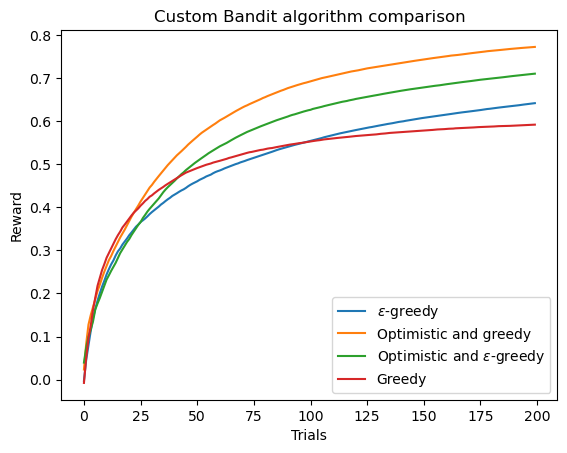

In [177]:
fig,ax = plt.subplots()
ax.plot(range(TRIALS),[ x/((n+1)*optimalMean) for n, x in enumerate(rvResultsEpsilonGreedyFinal)], label="$\epsilon$-greedy")
ax.plot(range(TRIALS),[ x/((n+1)*optimalMean) for n, x in enumerate(rvResultsGreedyOptimisticFinal)], label="Optimistic and greedy")
ax.plot(range(TRIALS),[ x/((n+1)*optimalMean) for n, x in enumerate(rvResultsEpsilonGreedyOptimisticFinal)], label="Optimistic and $\epsilon$-greedy")
ax.plot(range(TRIALS),[ x/((n+1)*optimalMean) for n, x in enumerate(rvResultsGreedyFinal)], label="Greedy")
ax.set_xlabel("Trials")
ax.set_ylabel("Reward")
ax.legend()
plt.title("Custom Bandit algorithm comparison")
plt.show()

We see that the Greedy algorithm has a better start than the other algorithms. However, on the long run, it performs the most poorly. We can see that it performs around 55%. That means that if an omniscient being could gain up to 100CHF with an optimal strategy after playing 200 times, we could hope for 55CHF by following the greedy algorithm instead.  Between the 3 algorithm that favors exploration, the optimistic and greedy one perform best, almost at 80% of performance. 


We also introduced this optimistic and $\epsilon$-greedy algorithm. For those parameters, in this case, it performs worse. It is probably due to the fact that the optimism is sufficiently large to push a good exploration of all bandits, so further investigation is counterproductive. Were the optimism lower, the drive for exploration would have been lesser and this variant could have performed best. Again, our goal here is not to optimize the parameters for each algorithm, but to compare each algorithm for our fixed parameters. 


To optimize the $\epsilon$-greedy algorithm, it is common to decrease the $\epsilon$ parameter over time. We did not implement this here; this gives an edge for the optimistic and greedy algorithm, which naturally explore only at the beginning, then keep exploiting. This is bad when occurs a change in the environment - a high mean on another bandit for instance. In this case, the optimistic and greedy algorithm could never notice and start to perform poorly.

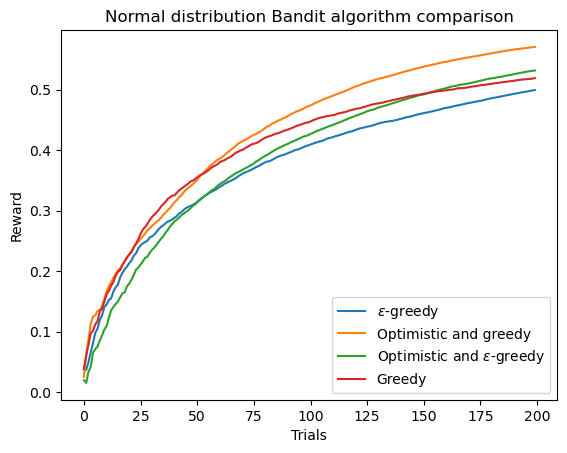

In [178]:
fig,ax = plt.subplots()
ax.plot(range(TRIALS),[ x/((n+1)*optimalMean) for n, x in enumerate(nResultsEpsilonGreedyFinal)], label="$\epsilon$-greedy")
ax.plot(range(TRIALS),[ x/((n+1)*optimalMean) for n, x in enumerate(nResultsGreedyOptimisticFinal)], label="Optimistic and greedy")
ax.plot(range(TRIALS),[ x/((n+1)*optimalMean) for n, x in enumerate(nResultsEpsilonGreedyOptimisticFinal)], label="Optimistic and $\epsilon$-greedy")
ax.plot(range(TRIALS),[ x/((n+1)*optimalMean) for n, x in enumerate(nResultsGreedyFinal)], label="Greedy")
ax.set_xlabel("Trials")
ax.set_ylabel("Reward")
ax.legend()
plt.title("Normal distribution Bandit algorithm comparison")
plt.show()

The comparison of the previous graph to this one is rather interesting. First, we can see that after 200 steps, the greedy algorithm performs still better than the $\epsilon$-greedy one. However, we can see that the curve are about to meet, thus giving the same podium in these two situations.

The custom bandits or the normal bandits are too similar to yields dramatic shift in this regard. However, if we look at performance, then we see that our algorithm perform way better on the custom bandit. For instance, we see a -25% drop of performance of the optimistic and greedy algorithm.  This is probably largely due to the fact that the variance on the custom bandit are in fact smaller than the variance on the normal bandit. This make exploration less rewarding, because with higher variance, more exploration must be done in order to have precise estimation. If we look at the greedy algorithm, then it is almost as good on both situation.

# Conclusion

We compare two different settings - the classical one, using normal law, and a custom one, using and list of values - and create a new strategy - to be optimistic and $\epsilon$-greedy at the same time.
We did not find any major difference in the results, except for the variance of the bandits. The custom setting could thus be a good framework for the introduction of the k-armed bandit problem. Reward on casino does not follow a normal low, but have a discrete set of reward instead. This is thus more close to the analogy, and have the advantage of using only discrete probabilities, which can be easier for some students. 

The optimistic and $\epsilon$-greedy strategy performed worst that the optimistic one, but a change on the optimism parameter could have yielded different results. Furthermore, this strategy could be perfectly fit in a situation where some changes are done during the steps. The optimism creates a great exploration at the start, and the random exploration until the end can help to detect a new optimal bandit. 
